# Extrinsics Calibration

In [1]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import numpy as np

from typing import List

import matplotlib.pyplot as plt

from dt_computer_vision.camera import CameraModel, Pixel

from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard8by6
from dt_computer_vision.camera.calibration.extrinsics.chessboard import find_corners
from dt_computer_vision.camera.calibration.extrinsics.rendering import draw_corners
from dt_computer_vision.camera.calibration.extrinsics.ransac import estimate_homography

In [2]:
this_dir: str = os.path.abspath('')
assets_dir: str = os.path.join(this_dir, "..", "assets", "extrinsics", "scenario0")
image_fpath: str = os.path.join(assets_dir, "frame0_distorted.jpg")
image: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoard8by6

camera_properties = {
    "width": 640,
    "height": 480,
    "K": [[295.79606866959824, 0.0, 321.2621599038631],
          [0.0, 299.5389048862878, 241.73616515312332],
          [0.0, 0.0, 1.0]],
    "D": [-0.23543978771661125,
          0.03637781479419574,
          -0.0033069818601306755,
          -0.0012140708179525926,
          0.0],
    "P": [[201.14027404785156, 0.0, 319.5586620845679, 0.0],
          [0.0, 239.74398803710938, 237.60151004037834, 0.0],
          [0.0, 0.0, 1.0, 0.0]]
}

camera = CameraModel(**camera_properties)

assert image.shape == (480, 640, 3)

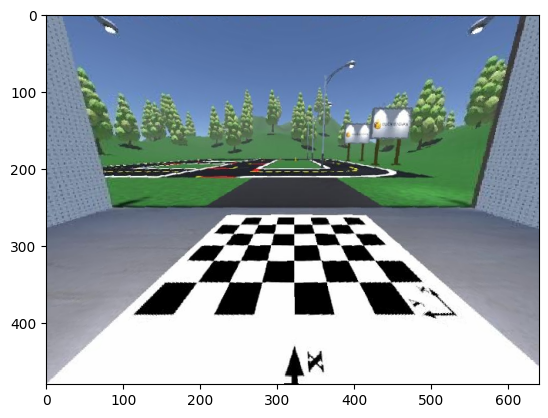

In [3]:
# rectify image
image = camera.rectifier.rectify(image)
rectified = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rectified)

In [4]:
# find corners
corners: List[Pixel] = find_corners(image, board)
print(f"Found {len(corners)} corners.")
assert len(corners) == (board.columns - 1) * (board.rows - 1)

Found 35 corners.


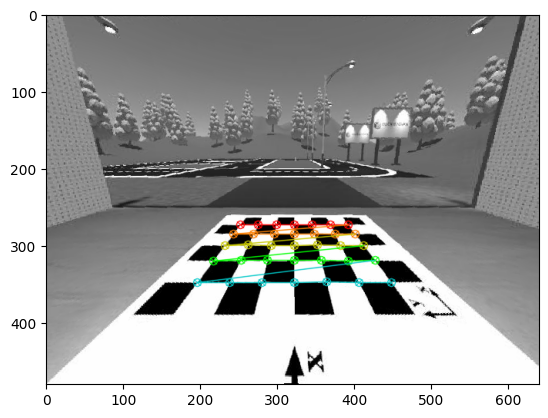

In [5]:
# draw detected corners on top of the image
image_w_corners = draw_corners(image, board, corners)
image_w_corners_rgb = cv2.cvtColor(image_w_corners, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_corners_rgb)

In [6]:
# estimate homography
H = estimate_homography(corners, board, camera)

In [7]:
print(H)

[[ 7.37170352e-04  1.66196570e-01  4.55469186e-01]
 [-5.89399450e-01  1.41577652e-03  1.14573749e-03]
 [ 4.12378174e-04  4.78708892e+00  1.00000000e+00]]


# Ground Reprojection

In [8]:
from typing import List
from dt_computer_vision.camera.calibration.extrinsics.chessboard import get_ground_corners_and_error, compute_placement_error

from dt_computer_vision.camera import NormalizedImagePoint
from dt_computer_vision.ground_projection import GroundPoint

image_corners: List[NormalizedImagePoint]
ground_corners: List[GroundPoint]
ground_corners_projected: List[GroundPoint]
errors: List[float]

image_corners, ground_corners, ground_corners_projected, errors = get_ground_corners_and_error(camera, corners, board, H)

for i, (image_corner, ground_corner, ground_corner_projected, error) in enumerate(zip(image_corners, ground_corners, ground_corners_projected, errors)):
    # print out (image point, ground computed, and ground oracle) points
    print(f"{i}\t: I[{image_corner}] -> Gc[{ground_corner_projected}] ~ G[{ground_corner}]: {float(error):.4f}m")

# compute average error
avg_error = np.average(errors)
std_error = np.std(errors)
print(f"Overall error: {avg_error:.4f}m +/- {std_error:.4f}m")

# find all corners that are on the X and Y axis of the calibration pattern (the lines partitioning the board into 4 equal quadrants)
placement_error: float = compute_placement_error(corners, board, errors)
print(f"Placement error: {placement_error:.4f}m")

0	: I[P(-0.2339, 0.1041)] -> Gc[P(0.3154, 0.0929)] ~ G[P(0.315, 0.093)]: 0.0004m
1	: I[P(-0.1553, 0.1051)] -> Gc[P(0.3146, 0.0618)] ~ G[P(0.315, 0.062)]: 0.0004m
2	: I[P(-0.0762, 0.1029)] -> Gc[P(0.3166, 0.031)] ~ G[P(0.315, 0.031)]: 0.0016m
3	: I[P(0.0015, 0.1037)] -> Gc[P(0.3159, 0.0003)] ~ G[P(0.315, 0.0)]: 0.0009m
4	: I[P(0.0818, 0.1058)] -> Gc[P(0.314, -0.0312)] ~ G[P(0.315, -0.031)]: 0.0010m
5	: I[P(0.1605, 0.1049)] -> Gc[P(0.3148, -0.0621)] ~ G[P(0.315, -0.062)]: 0.0002m
6	: I[P(0.2376, 0.1046)] -> Gc[P(0.3152, -0.0925)] ~ G[P(0.315, -0.093)]: 0.0006m
7	: I[P(-0.2637, 0.1449)] -> Gc[P(0.283, 0.0926)] ~ G[P(0.284, 0.093)]: 0.0011m
8	: I[P(-0.1765, 0.1461)] -> Gc[P(0.2823, 0.062)] ~ G[P(0.284, 0.062)]: 0.0017m
9	: I[P(-0.0867, 0.1437)] -> Gc[P(0.284, 0.0311)] ~ G[P(0.284, 0.031)]: 0.0001m
10	: I[P(0.0015, 0.1448)] -> Gc[P(0.2832, 0.0003)] ~ G[P(0.284, 0.0)]: 0.0008m
11	: I[P(0.0916, 0.1433)] -> Gc[P(0.2843, -0.0312)] ~ G[P(0.284, -0.031)]: 0.0004m
12	: I[P(0.1819, 0.1445)] -> Gc[P

# GUI

In [9]:
from matplotlib.pyplot import figure

from dt_computer_vision.camera.calibration.extrinsics.rendering import draw_gui, top_view_projected_corners
from dt_computer_vision.ground_projection.rendering import draw_grid_image

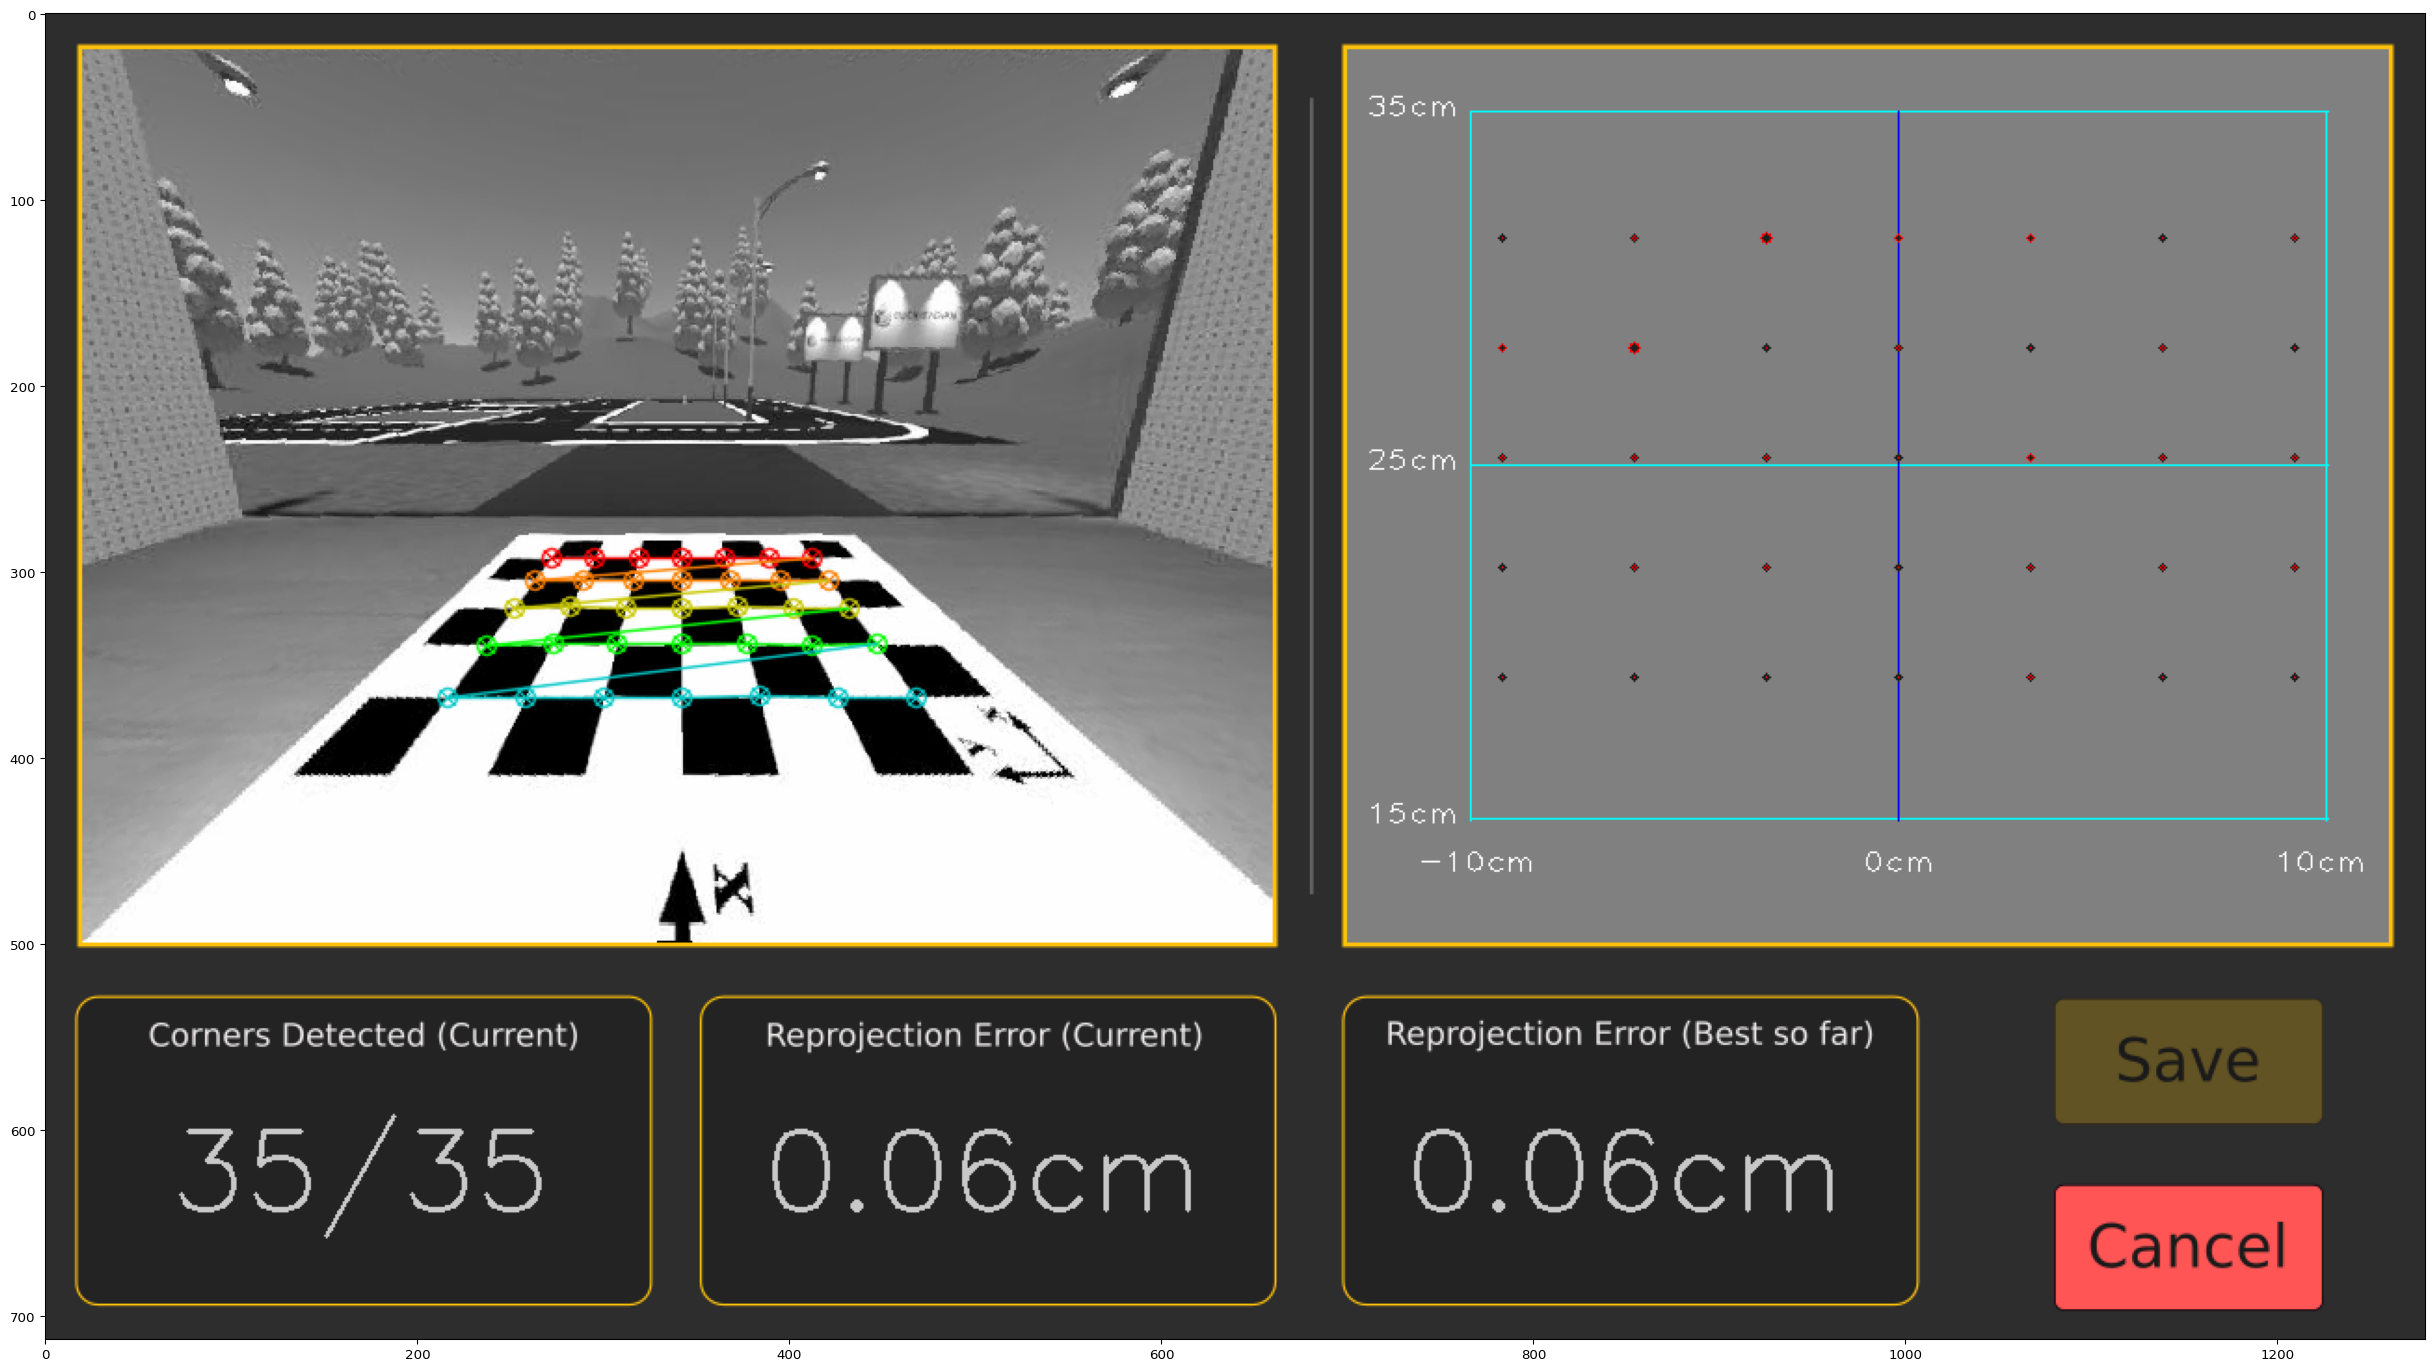

In [10]:
fig = figure(figsize=(32, 18), dpi=96)

right = top_view_projected_corners(
    ground_corners,
    errors,
    (560, 480),
    start_y=0.15,
)

gui = draw_gui(False, image_w_corners, right, len(corners), board, avg_error, avg_error)

gui = cv2.cvtColor(gui, cv2.COLOR_BGR2RGB)
plt.imshow(gui)

# Test on a quad

In [11]:
from typing import List
from dt_computer_vision.camera.calibration.extrinsics.chessboard import get_ground_corners_and_error, compute_placement_error

from dt_computer_vision.camera import NormalizedImagePoint
from dt_computer_vision.ground_projection import GroundPoint

# indices of the 4 outer corners of the grid, clock-wise from the Top-Left corner
corner_idxs: List[int] = [0, 6, 34, 28]

# true ground corners, easily reconstructable given a known board
ground_corners: List[GroundPoint] = board.corners()
ground_corners = [ground_corners[i] for i in corner_idxs]

# image corners, detected above
image_corners: List[NormalizedImagePoint] = [camera.pixel2vector(c) for c in corners]
image_corners = [image_corners[i] for i in corner_idxs]

errors: List[float] = []
ground_corners_projected: List[GroundPoint] = []
for image_corner, ground_corner in zip(image_corners, ground_corners):
    # project image point onto the ground plane
    ground_corner_projected = np.dot(H, [image_corner.x, image_corner.y, 1])
    # remove homogeneous coordinate
    ground_corner_projected = (ground_corner_projected / ground_corner_projected[2])[:2]
    # wrap x,y into a GroundPoint object
    ground_corner_projected_p = GroundPoint(
        round(ground_corner_projected[0], 4), round(ground_corner_projected[1], 4)
    )
    # store corner
    ground_corners_projected.append(ground_corner_projected_p)
    # compute error
    error = np.linalg.norm(ground_corner_projected - ground_corner.as_array())
    errors.append(error)

for i, (image_corner, ground_corner, ground_corner_projected, error) in enumerate(zip(image_corners, ground_corners, ground_corners_projected, errors)):
    image_corner_pxs = camera.vector2pixel(image_corner).as_integers()
    # print out (image point, image px, ground computed, and ground oracle) points
    print(f"{i}\t: I[{image_corner}]\t-> Ix{image_corner_pxs}\t-> Gc[{ground_corner_projected}] \t~ G[{ground_corner}]: {float(error):.4f}m")

0	: I[P(-0.2339, 0.1041)]	-> Ix[252 272]	-> Gc[P(0.3154, 0.0929)] 	~ G[P(0.315, 0.093)]: 0.0004m
1	: I[P(0.2376, 0.1046)]	-> Ix[391 273]	-> Gc[P(0.3152, -0.0925)] 	~ G[P(0.315, -0.093)]: 0.0006m
2	: I[P(0.4274, 0.3543)]	-> Ix[447 347]	-> Gc[P(0.1909, -0.0928)] 	~ G[P(0.191, -0.093)]: 0.0002m
3	: I[P(-0.422, 0.3536)]	-> Ix[196 347]	-> Gc[P(0.1909, 0.093)] 	~ G[P(0.191, 0.093)]: 0.0001m


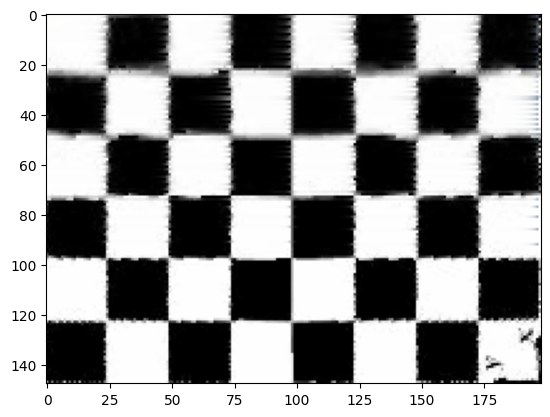

In [12]:
from typing import List, Tuple
from dt_computer_vision.camera.types import Point, Size, RegionOfInterest
from dt_computer_vision.camera.calibration.extrinsics.chessboard import compute_homography_maps

camera: CameraModel
H: np.ndarray
ppm: int = 800

roi: RegionOfInterest = RegionOfInterest(origin=Point(board.x_offset, board.y_offset), size=board.size)

mapx, mapy, mask, shape = compute_homography_maps(camera, H, ppm, roi)

img = cv2.remap(image, mapx, mapy, cv2.INTER_CUBIC)

img = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)

# flip and rotate the image so that it appears as it is seen from the camera
img = cv2.flip(img, 0)
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)